In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from skimage.transform import rotate
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from cell_utilities import *

Setting environment for Gordon


No vtk


In [2]:
stack = 'MD594'

In [3]:
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]

In [4]:
DETECTED_CELLS_DIR = os.path.join(DETECTED_CELLS_ROOTDIR, stack)

# Load processed cells

In [36]:
cells_aligned_padded = []
cells_addresses = []

for sec in [200, 201]:
    print sec
    
    c = load_cell_data(what='cells_aligned_mirrored_padded', stack=stack, sec=sec, ext='bp')
    cells_aligned_padded.append(c)

    n = c.shape[0]
    cells_addresses += [(stack, sec, i) for i in range(n)]
    
cells_aligned_padded = np.concatenate(cells_aligned_padded)

200
201


In [40]:
n_cells = len(cells_aligned_padded)
print n_cells, 'cells'

# cells_aligned_padded_flattened = np.reshape(cells_aligned_padded, (n_cells, -1))
# cells_aligned_padded.shape

cell_sizes = np.reshape(cells_aligned_padded, (n_cells, -1)).sum(axis=1)

181025 cells


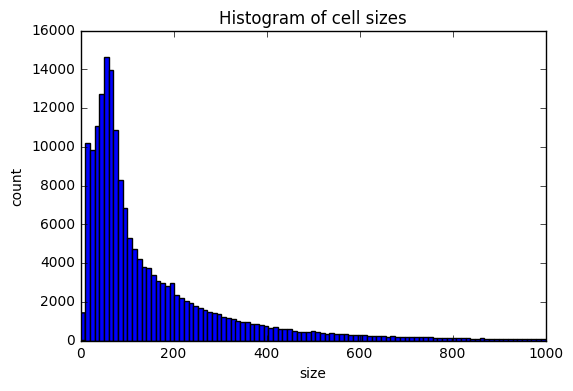

In [41]:
plt.hist(cell_sizes, bins=np.linspace(0, 1000, 100));
plt.title('Histogram of cell sizes');
plt.xlabel('size');
plt.ylabel('count');
plt.show();

In [42]:
# Select only the top 30% large cells and do spectral embedding only for them.

cutoff_percentage_small_medium = .3
cutoff_percentage_medium_large = .7
c1 = int(cutoff_percentage_small_medium*n_cells)
c2 = int(cutoff_percentage_medium_large*n_cells)
indices_sorted_by_size = np.argsort(cell_sizes)
small_cell_indices = indices_sorted_by_size[:c1]
medium_cell_indices = indices_sorted_by_size[c1:c2]
large_cell_indices = indices_sorted_by_size[c2:]

print 'threshold', cell_sizes[large_cell_indices].min()

n_small_cells = len(small_cell_indices)
n_medium_cells = len(medium_cell_indices)
n_large_cells = len(large_cell_indices)

print n_small_cells, n_medium_cells, n_large_cells

threshold 167
54307 72410 54308


In [43]:
selected_cell_indices = np.sort(large_cell_indices)
n_selected_cells = len(selected_cell_indices)

In [44]:
selected_cells_aligned_padded = cells_aligned_padded[selected_cell_indices].copy()
del cells_aligned_padded

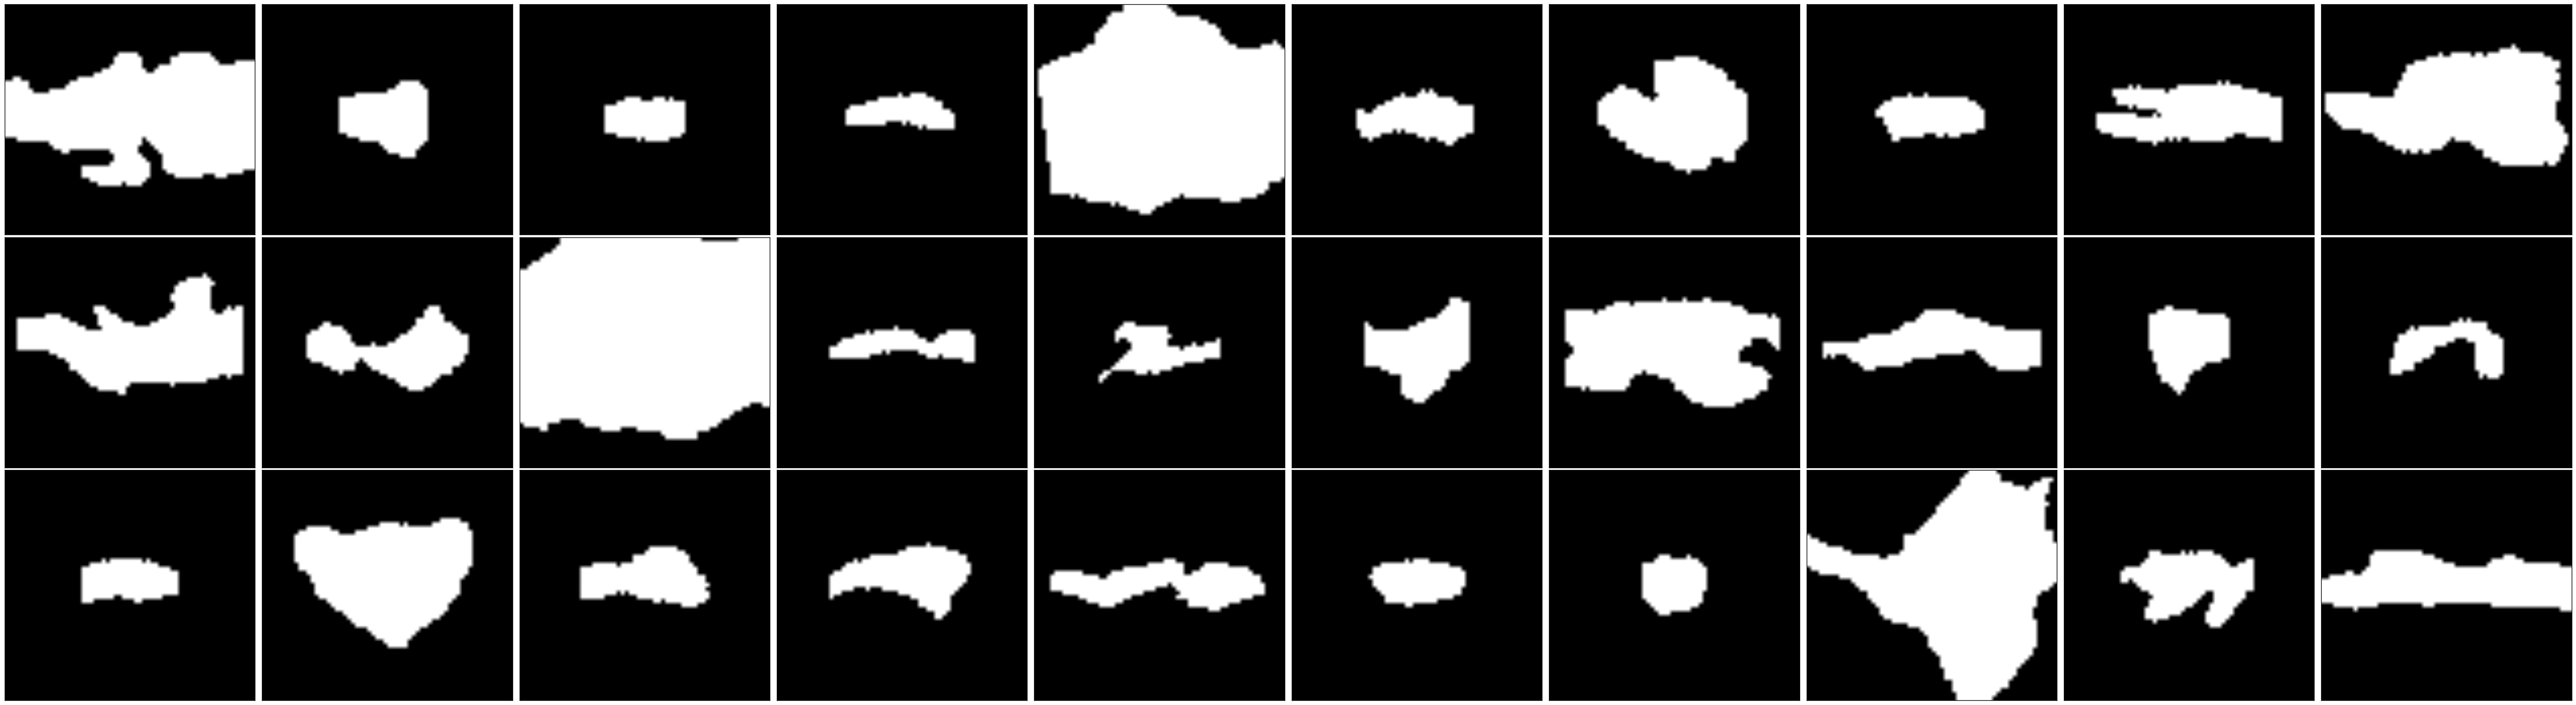

In [21]:
display_images_in_grids(selected_cells_aligned_padded[:30], nc=10, cmap=plt.cm.gray)

In [45]:
selected_cell_sizes = cell_sizes[selected_cell_indices]
selected_cell_addresses = [cells_addresses[i] for i in selected_cell_indices]

In [46]:
# dataset_name = 'largest30p'
# dataset_name = 'largest30p_sizeNormalized'

In [47]:
# CELL_EMBEDDING_DIR = create_if_not_exists(os.path.join(CELL_EMBEDDING_ROOTDIR, dataset_name))

In [48]:
# bp.pack_ndarray_file(selected_cells_aligned_padded, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded.bp' % dict(dataset_name=dataset_name)))

# Rescale all cells to the same size (optional)

In [49]:
mean_size = int(selected_cell_sizes.mean())
median_size = int(np.median(selected_cell_sizes))
print 'mean', mean_size, 'median', median_size

mean 400 median 297


In [ ]:
# Rescale all patches to mean = 400.

In [50]:
scale_factors = np.asarray([np.sqrt(float(mean_size)/s) for s in selected_cell_sizes])
# bp.pack_ndarray_file(scale_factors, 
#                      os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellResizeFactors.bp' % dict(dataset_name=dataset_name)))

In [51]:
def rescale_cell(i, mean_size):
    c = selected_cells_aligned_padded[i]
    s = selected_cell_sizes[i]
    scale_factor = np.sqrt(float(mean_size)/s)
    rescaled = rescale(c, scale_factor, cval=0) > .5
    xmin, xmax, ymin, ymax = bbox_2d(rescaled)
    rescaled_centered = rescaled[ymin:ymax+1, xmin:xmax+1].copy()
    return rescaled_centered

In [52]:
t = time.time()

pool = Pool(15)
selected_cells_aligned_rescaled = pool.map(lambda i: rescale_cell(i, mean_size), range(n_selected_cells))
pool.terminate()
pool.join()

sys.stderr.write('Scale to same size: %f s.\n' % (time.time()-t)) # 24s / 60k cells

Scale to same size: 13.489575 s.


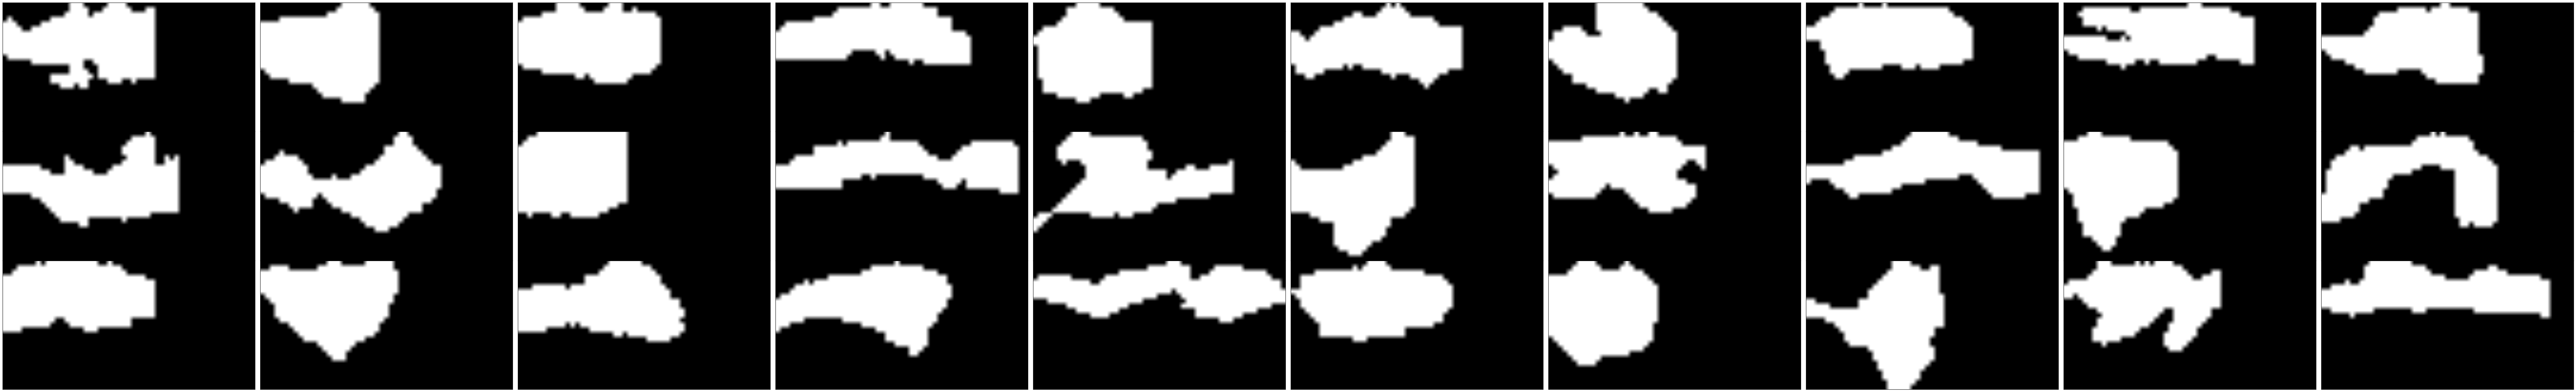

In [56]:
display_images_in_grids(selected_cells_aligned_rescaled[:30], nc=10, cmap=plt.cm.gray)

In [54]:
common_shape = (57,62)

In [55]:
selected_cells_aligned_rescaled_padded = np.asarray(pad_patches_to_same_size(selected_cells_aligned_rescaled, 
                                          pad_value=0, keep_center=True, common_shape=common_shape))

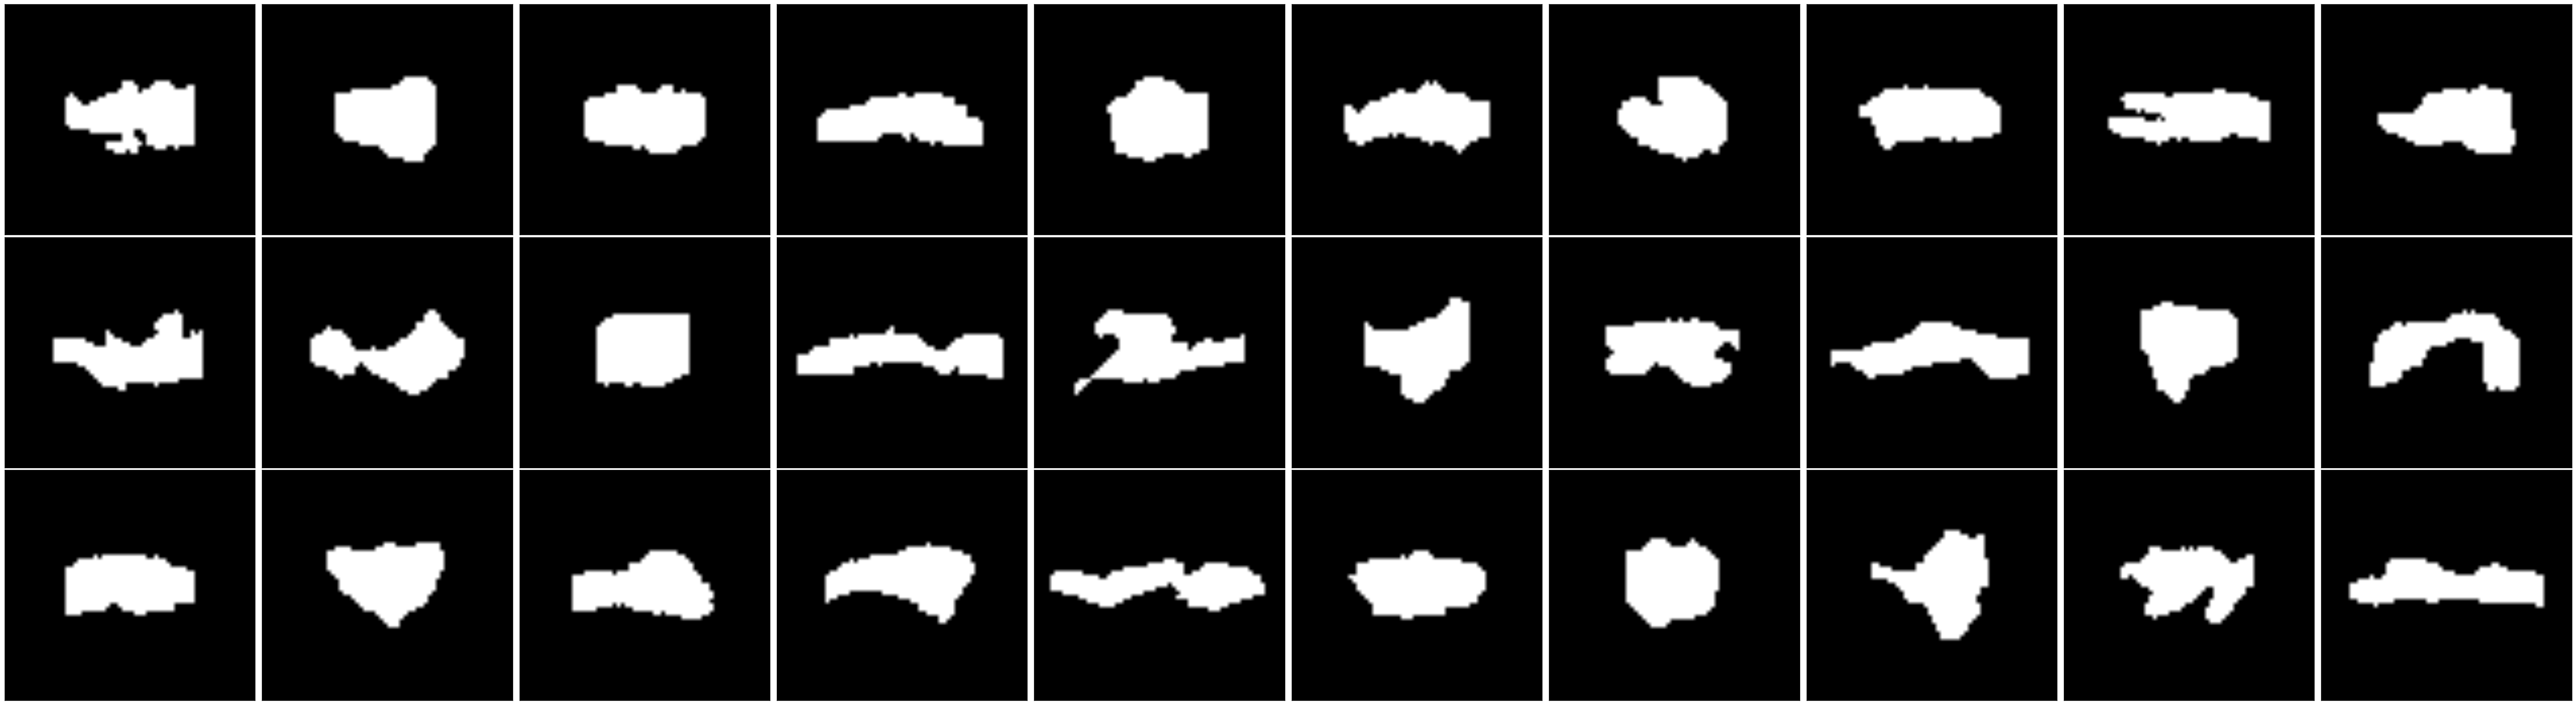

In [57]:
display_images_in_grids(selected_cells_aligned_rescaled_padded[:30], nc=10, cmap=plt.cm.gray)

In [58]:
selected_cells_aligned_rescaled_padded_flattened = np.reshape(selected_cells_aligned_rescaled_padded, (n_selected_cells, -1))
selected_cell_rescaled_sizes = selected_cells_aligned_rescaled_padded_flattened.sum(axis=1)

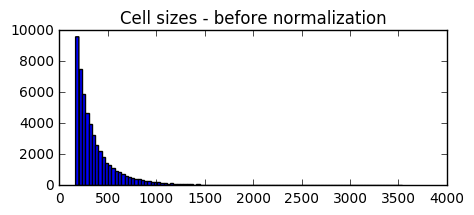

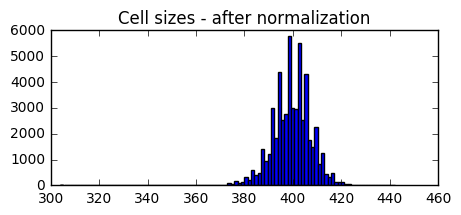

In [59]:
plt.figure(figsize=(5,2))
plt.hist(selected_cell_sizes, bins=100);
plt.title('Cell sizes - before normalization');
plt.show();

plt.figure(figsize=(5,2))
plt.hist(selected_cell_rescaled_sizes, bins=100);
plt.title('Cell sizes - after normalization');
plt.show();

In [122]:
bp.pack_ndarray_file(selected_cells_aligned_rescaled_padded, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(np.asarray(selected_cell_rescaled_sizes), 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_sizes.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(selected_cell_indices, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_indices.bp' % 
                     {'dataset_name': dataset_name}))

bp.pack_ndarray_file(np.asarray(selected_cell_addresses), 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_addresses.bp' % 
                     {'dataset_name': dataset_name}))

# KMeans++

In [61]:
set_selected_cell_arrays(selected_cells_aligned_rescaled_padded.reshape((n_selected_cells, -1)), 
                         selected_cell_rescaled_sizes)

In [62]:
def kmeans_plusplus(n_class):
    """
    compute_jaccard_i_vs_all() uses module-wide variables set by set_selected_cell_arrays().
    """
    
    seeds = np.empty((n_class, ), np.int)

    distances_to_closest_seed = np.empty((n_selected_cells, ))
    indices_of_closest_seed = np.empty((n_selected_cells, ), np.int)

    t1 = time.time()

    bar = show_progress_bar(0, n_class)

    for it in range(n_class):

        bar.value = it

        if it == 0:
            seed = np.random.randint(n_selected_cells)
        else:
            seed = np.random.choice(range(n_selected_cells), 1, p=d2_weights)[0]

        seeds[it] = int(seed)

    #     t = time.time()
        distances = 1. - compute_jaccard_i_vs_list(seed, 'all')
    #     print time.time() - t
        # sequential: 0.05-0.5s / 20k cells
        # parallel: 0.35s, even slower than sequential

        if it == 0:
            distances_to_closest_seed = distances
            indices_of_closest_seed[:] = 0
        else:    
            needs_update = distances < distances_to_closest_seed
            distances_to_closest_seed[needs_update] = distances[needs_update]
            indices_of_closest_seed[needs_update] = it
            
        d2s = distances_to_closest_seed**2
        d2_weights = d2s / d2s.sum()

    sys.stderr.write('Kmeans++: %.2f seconds.\n' % (time.time() - t1)) # 164s / 1000 centers
    
    return seeds, indices_of_closest_seed

In [63]:
seeds, indices_of_closest_seed = kmeans_plusplus(n_class=100)

Kmeans++: 11.81 seconds.


In [126]:
bp.pack_ndarray_file(seeds, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_kmeansppCenters.bp' % {'dataset_name': dataset_name}))

bp.pack_ndarray_file(indices_of_closest_seed, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_closestKmeansppCenters.bp' % \
                     {'dataset_name': dataset_name}))

# bp.pack_ndarray_file(memberCount, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_indices_kmeansppCentersMemberCount.bp' % \
#                     {'dataset_name': dataset_name}))

# Load Kmeans++ results

In [127]:
seeds = bp.unpack_ndarray_file(os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_kmeansppCenters.bp' % \
                               {'dataset_name': dataset_name}))

indices_of_closest_seed = bp.unpack_ndarray_file(os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_closestKmeansppCenters.bp' % \
                                                 {'dataset_name': dataset_name}))

print len(seeds), 'kmeans++ centers'

100 kmeans++ centers


In [64]:
memberCount = np.bincount(indices_of_closest_seed, minlength=len(seeds))
seedIndices_sorted_by_memberCount = np.argsort(memberCount)[::-1]
memberCount_sorted = memberCount[seedIndices_sorted_by_memberCount]
seeds_ranked_by_memberCount = seeds[seedIndices_sorted_by_memberCount]

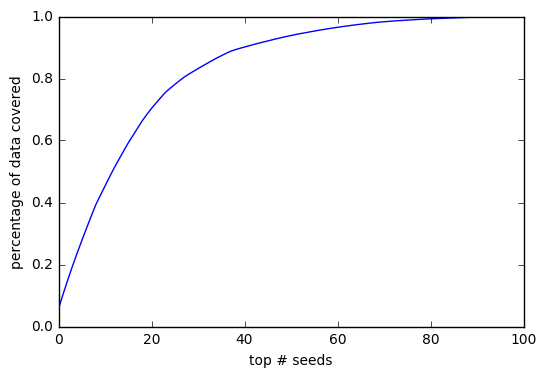

In [65]:
plt.plot(np.cumsum(memberCount_sorted) / float(n_selected_cells));
plt.xlabel('top # seeds');
plt.ylabel('percentage of data covered');

In [66]:
seeds_ranked_by_memberCount

array([ 4650, 53366, 44492, 23097, 13992, 51583, 26583, 33338, 45352,
       37443, 41120, 28539, 47412,  2125, 53744, 21714, 27666, 29410,
       40228, 16090, 17043, 14949, 25126, 11255,  5953, 30372,   416,
       49863, 52218,  7604,  4528, 18338, 17268, 13008, 50081, 10122,
        1971, 39717, 32104, 10908,  9536, 46454, 47363, 33364, 44391,
       53498, 43465,  5092, 40514,   630, 24235, 23673, 39504, 26688,
        9248, 32391, 20671,  1684, 26723, 42314, 44954,  9570, 44102,
       52429, 23248,  9275, 37507, 52635, 24566, 35332, 43924, 51128,
       20951, 38968, 50310, 53351,  3122, 51564, 50853, 30322, 49102,
       54088, 28937, 20591, 31888, 11623,  9951,  6629, 36322,  8030,
       26845, 20300, 43223,  4904, 13881, 23563, 10318, 42895, 28755, 25374])

In [139]:
def compute_embedding(sample_indices, nonsample_indices=None):
    """
    compute_jaccard_i_vs_all() uses module-wide variables set by set_selected_cell_arrays().
    """
    
    n_samples = len(sample_indices)
    
    t = time.time()

    affinities_with_samples = compute_jaccard_list_vs_all(sample_indices)

    sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t)) # 10 s / 200
    
    if nonsample_indices is None:
        nonsample_indices = np.setdiff1d(range(n_selected_cells), sample_indices)
        
    permutation = np.r_[sample_indices, nonsample_indices]

    ########################

    t = time.time()

    from scipy.linalg import sqrtm

    A = affinities_with_samples[:, sample_indices].copy()
    B = affinities_with_samples[:, nonsample_indices].copy()

    d1 = np.sum(np.c_[A, B], axis=1)
    Ai = np.linalg.inv(A)
    d2 = np.sum(B, axis=0) + np.dot(B.T, np.dot(Ai, np.sum(B, axis=1)))
    dhat_si = np.sqrt(1./np.r_[d1, d2])
    A = A*np.outer(dhat_si[:n_samples], dhat_si[:n_samples])
    B = B*np.outer(dhat_si[:n_samples], dhat_si[n_samples:])

    if any(np.linalg.eigvals(A) < 0):
        # A is indefinite
        print 'A is indefinite'

        U, L, UT = np.linalg.svd(A)

        Ubar = np.c_[U.T, np.dot(np.dot(np.linalg.inv(np.diag(L)), U.T), B)]
        Z = np.dot(Ubar.T, np.diag(np.sqrt(L)))
        F, S, FT = np.linalg.svd(np.dot(Z.T, Z))
        V = np.dot(np.dot(Z, F), np.linalg.inv(np.diag(np.sqrt(S))))

    else:
        # A is positive definite
        print 'A is positive definite'
        
        Asi = sqrtm(Ai)

        M = np.dot(B.T, Asi)
        print M[0]
        
        S = A + np.dot(M.T, M)

        U, L, T = np.linalg.svd(S)

        V = np.dot(np.vstack([A, B.T]), np.dot(Asi, np.dot(U, np.linalg.inv(np.diag(np.sqrt(L))))))

    sys.stderr.write('Nystroem: %f s.\n' % (time.time()-t))


    ##########################

    E_allEig = V[:,1:]/V[:,0][:,None]

#     E_allEig_original_order = np.zeros_like(E_allEig)
    E_allEig_original_order = np.zeros((n_selected_cells, 99))
    E_allEig_original_order[permutation] = E_allEig
    
    return E_allEig_original_order

In [140]:
nystrom_sample_indices = seeds_ranked_by_memberCount[:100].copy() # Use top n_nystrom_samples most populated kmeans++ centers

In [141]:
nonsample_indices_1 = np.setdiff1d(range(n_selected_cells), nystrom_sample_indices)[:100]
embeddings_1 = compute_embedding(nystrom_sample_indices, nonsample_indices_1)

A is positive definite
[  7.92670335e-04   3.49988242e-04   8.11718704e-04   6.53894458e-04
   3.64357803e-04   5.06079780e-04   4.48837960e-04   8.83789687e-04
   5.46909619e-04   4.39249496e-04  -1.75862381e-05   9.84366544e-04
   1.17716426e-04   9.02117281e-04   8.30409800e-04   7.99838491e-04
   1.24610183e-03   1.53575253e-03   8.36713963e-04   5.41151448e-04
   2.24677106e-04   8.17078814e-04   5.72667287e-04   3.19184613e-04
   8.73629652e-04   1.39567878e-04   7.24340375e-04   3.52094470e-04
   6.39543005e-04   7.56867088e-04   3.95615057e-04   6.66873406e-04
   1.25515915e-03   7.25170139e-04   1.62117157e-03   1.04847752e-03
   5.27768010e-04   1.52795659e-03   8.58173312e-04   1.17732886e-03
   5.53225766e-04   1.36009724e-03   6.67648668e-04   5.71547244e-04
   4.71825344e-04   8.33092146e-04   5.89157807e-04   9.55350360e-04
   4.69924730e-04   4.36987326e-04  -8.52406659e-05   7.69220052e-04
   6.60359916e-04   1.09371426e-03   7.13049378e-04   8.01706550e-04
   1.018572

Compute pairwise affinities (with samples): 1.370215 s.
Nystroem: 0.087977 s.


In [143]:
nonsample_indices_2 = np.setdiff1d(range(n_selected_cells), nystrom_sample_indices)[1000:2000]
embeddings_2 = compute_embedding(nystrom_sample_indices, nonsample_indices_2)

A is positive definite
[  2.00385078e-04   5.16578716e-05   7.91438063e-05   9.82414743e-05
   1.28267068e-04   2.19667440e-04   1.82177411e-04   1.91981336e-04
   1.32436302e-04   3.40088901e-05   1.07419306e-04   7.51404767e-05
   2.05718680e-04   2.30452442e-04   1.59840458e-04   8.63276976e-05
   1.13359119e-04   1.31739253e-04   9.47846957e-05   2.20202371e-04
   1.24625303e-04   1.17134360e-04   6.70218950e-05   6.53010862e-05
   1.23182201e-04   5.35327696e-05   1.02513366e-04   5.77679051e-05
   7.59559662e-05   1.42957514e-04   1.42813418e-04   1.59397700e-04
   5.16810462e-05   1.13324138e-04   1.08707166e-04   1.17460189e-04
   1.40290597e-04   9.72952427e-05   1.36952577e-04   7.04353683e-05
   1.67643740e-04   1.48796478e-04   1.10605878e-04   2.28590594e-04
   1.18744118e-04   1.87080954e-04   1.50485325e-04   9.18762150e-05
   1.29097356e-04   8.85722866e-05   2.15668027e-04   1.45725073e-04
   1.25598530e-04   1.65758412e-04   1.07873679e-04   1.69150854e-04
   1.480892

Compute pairwise affinities (with samples): 1.382036 s.
Nystroem: 0.090509 s.


In [132]:
# our data, Nystroem extension
# https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf

# for n_nystrom_samples in [100]:
for n_nystrom_samples in [10, 100, 300, 1000]:
    nystrom_sample_indices = seeds_ranked_by_memberCount[:n_nystrom_samples].copy() # Use top n_nystrom_samples most populated kmeans++ centers
    embeddings = compute_embedding(nystrom_sample_indices)

    embeddings_normalized = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

    bp.pack_ndarray_file(embeddings, os.path.join(CELL_EMBEDDING_DIR, 'embeddings_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                         {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples}))
    bp.pack_ndarray_file(embeddings_normalized, os.path.join(CELL_EMBEDDING_DIR, 'embeddings_normalized_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                         {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples}))

A is positive definite


Compute pairwise affinities (with samples): 1.190973 s.
Nystroem: 0.023083 s.
Compute pairwise affinities (with samples): 3.616016 s.


A is positive definite


Nystroem: 0.473060 s.
Compute pairwise affinities (with samples): 3.831330 s.


A is positive definite


Nystroem: 0.439004 s.
Compute pairwise affinities (with samples): 3.551076 s.


A is positive definite


Nystroem: 0.429481 s.


In [72]:
print embeddings.shape

(27454, 99)
